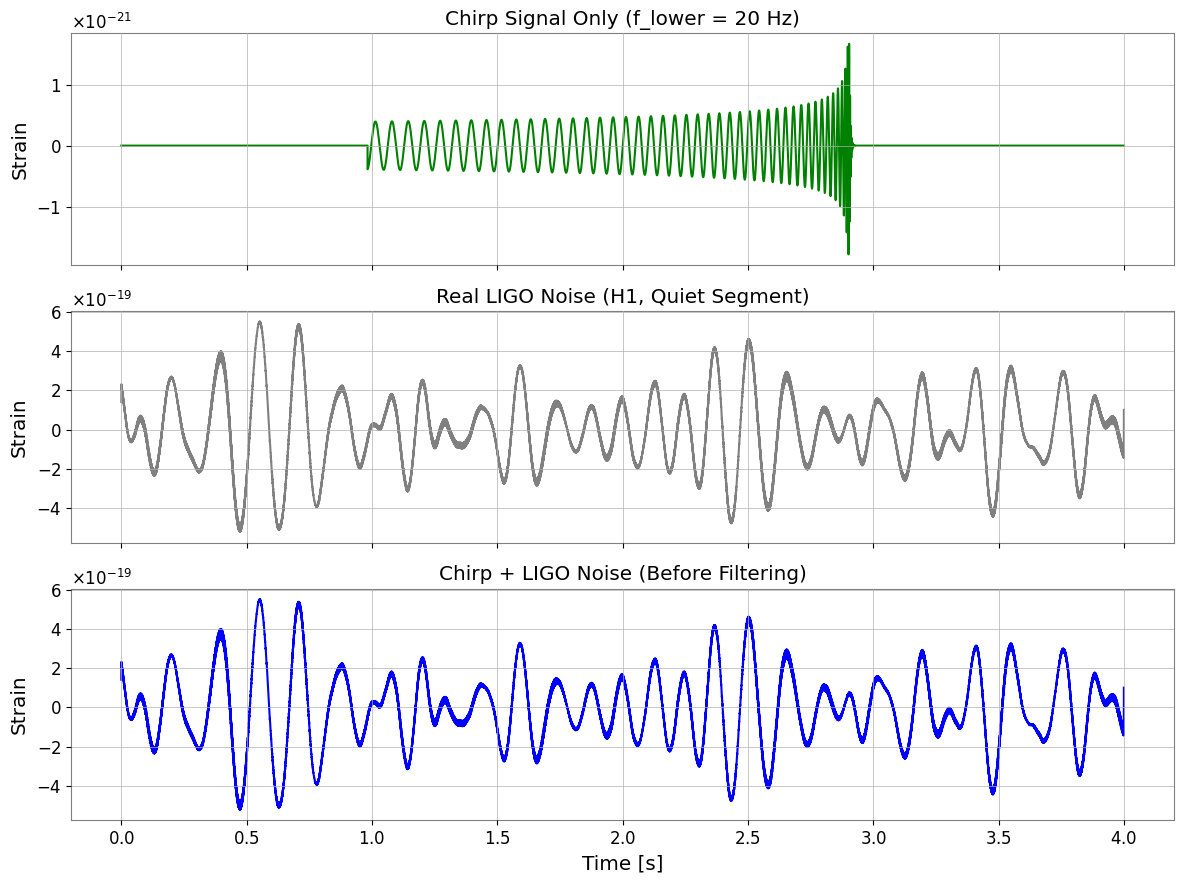

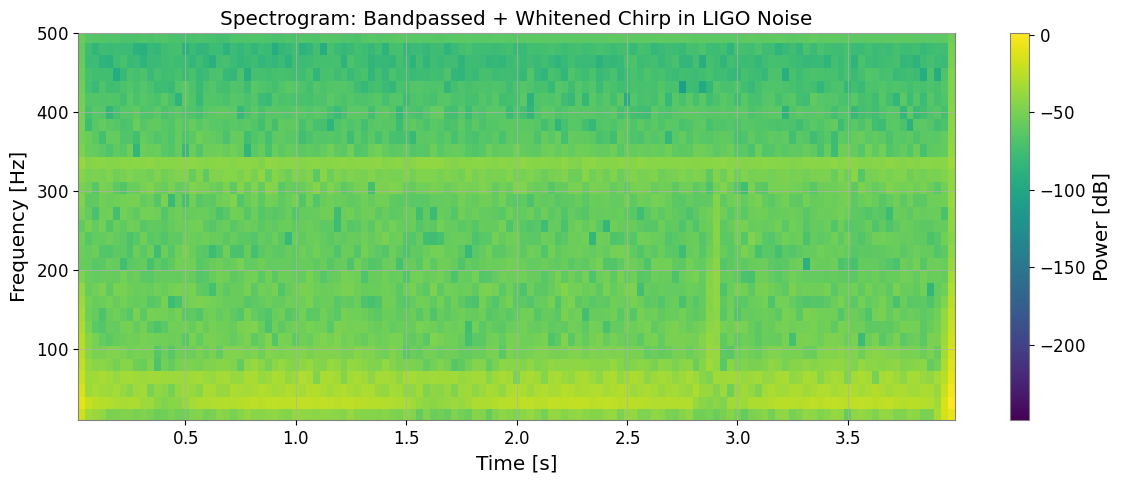

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from gwpy.timeseries import TimeSeries
from scipy.signal import spectrogram, butter, filtfilt

# --- Parameters ---
sample_rate = 16384  # High resolution
duration = 4  # seconds
n_samples = int(duration * sample_rate)
time = np.linspace(0, duration, n_samples)

# --- Step 1: Use a Quiet Segment (before GW150914) ---
quiet_gps = 1126259446  # 16 seconds before the event
strain = TimeSeries.fetch_open_data('H1', quiet_gps, quiet_gps + duration)
strain = strain.resample(sample_rate)
ligo_noise = strain.value

# --- Step 2: Generate Chirp Waveform (30 + 30 M☉, f_lower = 20 Hz) ---
hp, _ = get_td_waveform(approximant='SEOBNRv4_opt',
                        mass1=30, mass2=30,
                        delta_t=1/sample_rate,
                        f_lower=15,
                        distance=400)

chirp_array = hp.numpy()

# --- Step 3: Pad/Trim Chirp and Inject into Noise ---
chirp_padded = np.zeros(n_samples)
start_idx = n_samples // 2 - len(chirp_array) // 2
end_idx = start_idx + len(chirp_array)
chirp_padded[start_idx:end_idx] = chirp_array[:min(len(chirp_array), n_samples)]
injected = ligo_noise + chirp_padded

# --- Step 4: Bandpass Filter (30–350 Hz) ---
def bandpass(data, fs, low, high, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [low / nyq, high / nyq], btype='band')
    return filtfilt(b, a, data)

injected_bp = bandpass(injected, fs=sample_rate, low=30, high=350)

# --- Step 5: Whiten ---
def whiten(data):
    return (data - np.mean(data)) / np.std(data)

injected_clean = whiten(injected_bp)

# --- Step 6: Time-Domain Plots ---
fig, axs = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

axs[0].plot(time, chirp_padded, color='green')
axs[0].set_title("Chirp Signal Only (f_lower = 20 Hz)")
axs[0].set_ylabel("Strain")
axs[0].grid(True)

axs[1].plot(time, ligo_noise, color='gray')
axs[1].set_title("Real LIGO Noise (H1, Quiet Segment)")
axs[1].set_ylabel("Strain")
axs[1].grid(True)

axs[2].plot(time, injected, color='blue')
axs[2].set_title("Chirp + LIGO Noise (Before Filtering)")
axs[2].set_xlabel("Time [s]")
axs[2].set_ylabel("Strain")
axs[2].grid(True)

plt.tight_layout()
plt.show()

# --- Step 7: Spectrogram ---
f, t_spec, Sxx = spectrogram(injected_clean, fs=sample_rate,
                             nperseg=1024, noverlap=512)  # Higher resolution

plt.figure(figsize=(12, 5))
plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='auto')
plt.title("Spectrogram: Bandpassed + Whitened Chirp in LIGO Noise")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.ylim(10, 500)
plt.colorbar(label='Power [dB]')
plt.tight_layout()
plt.show()

